based on https://github.com/hardmaru/estool/blob/master/simple_es_example.ipynb

# The Brachistochrone

The Brachistochrone is a physics problem posed by Johann Bernoulli in 1696.

What path gives us the shortest distance between two points? As most people know, in flat space the answer is a line. 

What path gives us the *shortest time* between two points? Assuming we are in a uniform gravitation field, the Brachistochrone curve is the path that minimizes the amount of time it takes to get from point A to point B. What does this Brachistochrone curve look like?

To set up the problem, we assume that point $a$ is located at $(0,0)$, and that point $b$ is at point $(x_f,y_f)$ and all points on the path have $y \leq 0$. Starting with a particle at rest at point $a$, and using conservation of energy $E = T + U$, we know that at point $a$ the total energy is 0, and at any other point $(x,y)$ on the curve, the energy is $\frac{1}{2}mv^2 - mgy = 0$.  From this we get the following equation for the velocity of the particle:

$$ v = \sqrt{2 g y}$$

$s$ is the path the particle takes, so we know $\frac{ds}{dt} = v$. We can then rearrange the equation to get $\frac{ds}{v} = dt$ and integrate to get

$$ \Delta t = \int_a^b \frac{ds}{\sqrt{2 g y}}$$

We can express our goal as trying to find the path $s$ such that $\Delta t$ is minimum. Rearranging the variables we have

$$ \Delta t = \int_a^b \frac{\sqrt{dx^2 + dy^2}}{\sqrt{2 g y}} = \int_0^x \sqrt{\frac{1+ y'(x)}{2 g y}} dx = \int_0^x f\{y,y';x\} dx $$

So $\Delta t$ is a functional (its arguments are functions). We need to find the function $y$ and $y'$ that will minimize its value. Classicaly, this is a problem in the Calculus of Variations. Solving it requires plugging $f$ into the Euler-Lagrange equation and solving the resulting differential equation to find $y$.

$$ \frac{df}{dy} - \frac{d}{dx}\frac{df}{dy'} = 0 \qquad \text{Euler-Lagrange} $$

Plugging in $f$ into the above equation eventually leads to the differential equation of a cycloid.

$$ \left(\frac{dy}{dx}\right)^2 = \frac{2k-y}{y} $$

So in other words, the shape of the Brachistochrone curve is a cycloid. Cycloids cannot be expressed in closed form, but can be expressed in parametric form. 

$$ x = k(\theta-\sin\theta) \qquad y = k(1-\cos\theta) $$

k is the radius of the circle the cycloid is being drawn by. k is found by using the condition that the cycloid must pass through the point $(x_f,y_f)$. 

## Approximating the cycloid 

We can expand the cycloid function in a fourier series to get an approximation of the function and its derivative:

$$ y(x) \approx a_0 + \sum_{i=1}^n a_n \cos{\frac{xn}{2k}} + b_n \sin{\frac{xn}{2k}} \qquad y'(x) \approx \sum_{i=1}^n \frac{n b_n}{2k} \cos{\frac{xn}{2k}} -\frac{n a_n}{2k} \sin{\frac{xn}{2k}} $$

And we can get the fourier coeffcients with the following equation:

$$ a_n = \frac{1}{2\pi k} \int_{-2\pi k}^{2\pi k} y(x) \cos(\frac{nx}{2 k}) dx \qquad b_n = \frac{1}{2\pi k} \int_{-2\pi k}^{2\pi k} y(x) \sin(\frac{nx}{2 k}) dx $$

Since we can only express the cycloid parameterically, we change all the variables to $\theta$:

$$ a_n = \frac{k}{2\pi} \int_{-2\pi}^{2\pi}(1-\cos{\theta})^2 \cos(\frac{n}{2} (\theta-\sin{\theta})) d\theta \qquad b_n = \frac{k}{2\pi} \int_{-2\pi}^{2\pi}(1-\cos{\theta})^2 \sin(\frac{n}{2} (\theta-\sin{\theta})) d\theta = 0 $$ 

All the $b_n$ will be zero because the cycloid is an even function. We can then plug in this $y(x)$ and $y'(x)$ in our $\Delta t$ equation to actually see what the minimal time is. Of course, to get a good approximation of the cycloid, we will need quite a few terms in the fourier expansion.

In [2]:
import numpy as np
import scipy
import sys, math
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import cma
from es import SimpleGA, CMAES, PEPG, OpenES

In [3]:
#constants
XFINAL = 10.0
YFINAL = -5.
FOURIER_TERMS = 20
g = -9.8 #m/s^2
K = 2.585999608432 #radius of the cycloid that draws the brachistochrone curve. Gotten numerically from Mathematica
TFINAL = 3.50837   #angle of the cycloid at (XFINAL,YFINAL). Gotten numerically from Mathematica

#Mathematica equation to numerically solve the parametric equation of a cycloid
#FindRoot[Evaluate[{K*(t - Sin[TFINAL]) == XFINAL, K*(1 - Cos[TFINAL]) == YFINAL}], {K, 5}, {TFINAL, 3.2}, MaxIterations -> 1000]


In [4]:
def cycloid_coefficients(n):
    # n is number of sine coefficients and n+1 the number of cosine coeffcieints. 
    # change of variables to theta is necessary since cannot write in terms of y(x).
    # sine terms are all 0. cosine terms are non-zero.
    coefs = [0]*(2*n+1)
    def cos_coef(c,theta):
        return ((1-np.cos(theta))**2)*(np.cos((c/2.)*(theta-np.sin(theta))))
    def sin_coef(c,theta):
        return ((1-np.cos(theta))**2)*(np.sin((c/2.)*(theta-np.sin(theta))))
    for i in range(n):
        coefs[2*i] = -1.0*(K/(2.*np.pi))*integrate.quad(lambda x: cos_coef(i,x),-2*np.pi,2*np.pi,limit=200)[0]
        coefs[2*i+1] = 0
    coefs[0] = coefs[0]/2.0
    coefs[2*n] = -1.0*(K/(2.*np.pi))*integrate.quad(lambda x: cos_coef(n,x),-2*np.pi,2*np.pi,limit=200)[0]
    return np.array(coefs)

def fourier_y(c_list,x):
    # Given a list of coefficients c_list, f(x) is the fourier expansion. 
    # f(x) = a0 + sum(an*cos(nx) + bn*sin(nx))
    # even entries in c_list are the a_n, odd entries are the b_n. 
    #c_list should always have odd len(c_list).
    a = c_list[::2]
    b = c_list[1::2]
    cosines = np.array([np.cos(x*n/(2.*K)) for n in range(len(a))])
    sines = np.array([np.sin(x*n/(2.*K)) for n in range(1,len(b)+1)])
    result = (np.dot(a,cosines)+np.dot(b,sines))
    # the result cannot have f(x) > 0 due to conservation of energy
    if np.isscalar(result):
        return result if result < 0 else -0.00001
    return np.array([i if i < 0 else -0.00001 for i in result])

def fourier_yp(c_list,x):
    #derivative of the function f(x)
    #f' = sum(n*bn*cos(nx)-n*an*sin(nx))
    a = c_list[::2]
    b = c_list[1::2]
    cosines = np.array([(n/(2.*K))*np.cos(x*n/(2.*K)) for n in range(1,len(b)+1)])
    sines = np.array([-(n/(2.*K))*np.sin(x*n/(2.*K)) for n in range(1,len(a))])
    result = np.dot(a[1:],sines)+np.dot(b,cosines)
    return result

def delta_time(c_list):
    c_list = np.copy(c_list)
    def f(x):
        #equation gotten from conservation of energy
        #due to conservation of energy, values of f(x) > 0 are impossible.
        #they will create a negative inside the sqrt and return an NaN
        return np.sqrt((1+fourier_yp(c_list,x)**2)/(2.0*g*fourier_y(c_list,x)))
    time = integrate.quad(f,0.0001,XFINAL,limit=200)[0] #don't start integration from zero-- messes up integrator.
    return time

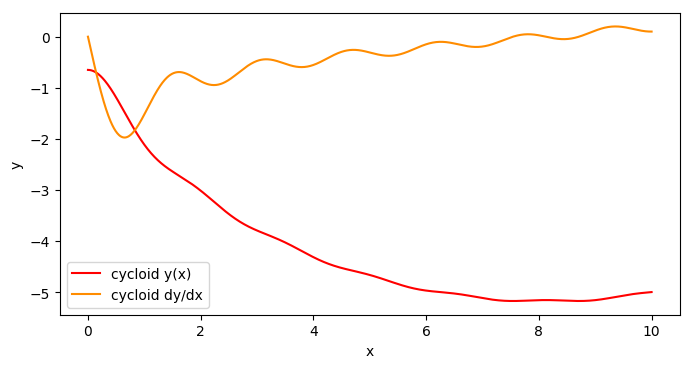

Delta t: 1.4703260179643727 s


In [5]:
%matplotlib inline

xaxis = np.linspace(0, XFINAL, 1000)
cycloid_coefs = cycloid_coefficients(FOURIER_TERMS)
yaxis_cycloid = fourier_y(cycloid_coefs,xaxis)
ypaxis_cycloid = fourier_yp(cycloid_coefs,xaxis)
plt.figure(figsize=(8,4), dpi=100)
cycloid_y, = plt.plot(xaxis, yaxis_cycloid, color="red",label='cycloid y(x)')
cycloid_yp, = plt.plot(xaxis, ypaxis_cycloid, color="darkorange",label='cycloid dy/dx')
plt.legend(handles=[cycloid_y, cycloid_yp], loc=3)
plt.xlabel('x')
plt.ylabel('y')
plt.show()
print('Delta t:',delta_time(cycloid_coefs),'s')

# Alternative functions

To see how other functions compare to the optimal cycloid, we can decompose them into their fourier coeffcients and plug them into $\Delta t$ just the same. One such example is the straight line that connects $a = (0,0)$ to $b  = (x_f,y_f)$. The coeffcients for the line are:


$$ a_n = \frac{1}{2\pi k} \int_{-2\pi k}^{2\pi k} \frac{y_f}{x_f}x \cos(\frac{nx}{2 k}) dx = 0 \qquad b_n = \frac{1}{2\pi k} \int_{-2\pi k}^{2\pi k} \frac{y_f}{x_f}x \sin(\frac{nx}{2 k}) dx $$

All the $a_n$ will be zero because the line is an odd function. If we use few terms in the fourier expansion, the result will not look like a straight line.

In [7]:
def line_coefficients(n):
    # n is number of sine coefficients and n+1 the number of cosine coeffcieints.
    # The line starts at (0,0) and ends at (XFINAL,YFINAL)
    # all Cosine terms are 0. Sine terms non-zero
    coefs = [0.0]*(2*n+1)
    def cos_coef(c,theta):
        return (YFINAL*theta/XFINAL)*(np.cos(c*theta/(2.*K)))
    def sin_coef(c,theta):
        return (YFINAL*theta/XFINAL)*(np.sin(c*theta/(2.*K)))
    for i in range(n):
        coefs[2*i] = 0.0
        coefs[2*i+1] = (1.0/(2.*np.pi*K))*integrate.quad(lambda x: sin_coef(i+1,x),-2*np.pi*K,2*np.pi*K,limit=200)[0]
    return np.array(coefs)

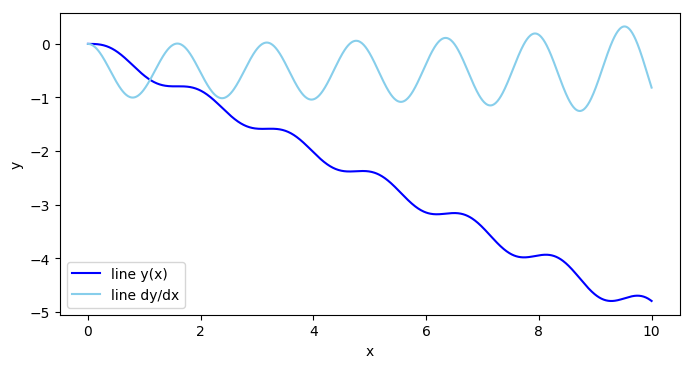

Delta t: 40.855786576035555 s


In [8]:
line_coefs = line_coefficients(FOURIER_TERMS)
yaxis_line = fourier_y(line_coefs,xaxis)
ypaxis_line = fourier_yp(line_coefs,xaxis)
plt.figure(figsize=(8,4), dpi=100)
line_y, = plt.plot(xaxis, yaxis_line, color="blue",label='line y(x)')
line_yp, = plt.plot(xaxis, ypaxis_line, color="skyblue",label='line dy/dx')
plt.legend(handles=[line_y, line_yp], loc=3)
plt.xlabel('x')
plt.ylabel('y')
plt.show()
print('Delta t:',delta_time(line_coefs),'s')

# Evolution Strategies and the Brachistochrone

Rather than using the Euler-Lagrange equation to solve the problem, we can use ML to find the optimal curve. Essentially we will try to minimize the $\Delta t$ function by crawing around in fourier space until we find the coefficients that return the minimum function.

A random set of fourier coefficients will create a random curve. This curve may go above the $y=0$ line, which violates conservation of energy. A random curve will also likely not respect the boundry conditions of $a = (0,0)$ and $b  = (x_f,y_f)$. If we want to use an ML algorithm to find the brachistochrone curve, we need to create a reward function that uses the $\Delta t$ function as a basis, and then has extra terms that heavily penalizes curves that do not follow the boundry conditions and conservation of energy. 

We can then use this new reward function as the fit function for the CMA-ES or OpenAI-ES algorithms. Fourier coefficients that return a lower $\Delta t$ and respect the laws of nature will recieve a higher reward and pass on their coefficients to the next generation. 

For the case where we are using few fourier coefficients, the approximation of the cycloid may not be optimal, and the ES alogorithms may very well do better than our benchmark.

In [9]:
def cost_function(c_list):
    c_list = np.copy(c_list)
    def cost(x):
        #equation gotten from conservation of energy
        #due to conservation of energy, values of f(x) > 0 are impossible.
        #they will create a negative inside the sqrt and return an NaN
        return np.sqrt((1+fourier_yp(c_list,x)**2)/(2.0*g*fourier_y(c_list,x)))
    time = integrate.quad(cost,0.0001,XFINAL,limit=200)[0] #don't start integration from zero-- messes up integrator.
    #we also want to constrain the path to begin at (0,0) and end at (XFINAL,YFINAL)
    begin_penalty = math.fabs(fourier_y(c_list,0.0001)-(-0.00001))**3
    end_penalty = math.fabs(fourier_y(c_list,XFINAL)-YFINAL)**3
    return -1.*time-begin_penalty-end_penalty

fit_func = cost_function

In [8]:
NPARAMS = (FOURIER_TERMS*2)+1 #Our parameters are all our fourier coefficients
NPOPULATION = 50    # use population size of 50.
MAX_ITERATION = 200 # run each solver for 300 generations.

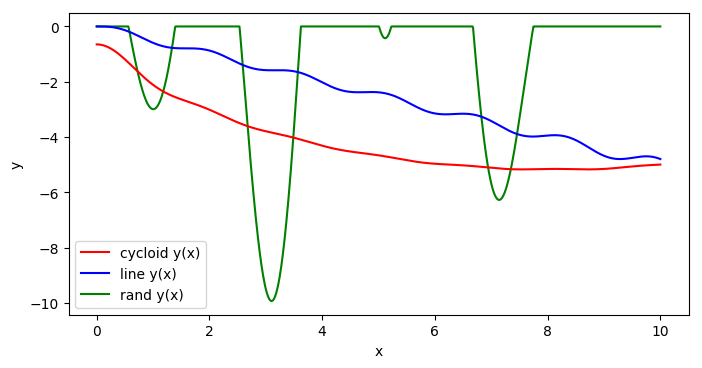

CYCLOID:
  fitness: -1.7441541442885375
LINE:
  fitness: -40.864266623355554
RANDOM:
  fitness: -5613.106208274444


/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [45]:
rand_coefs = np.random.randn(NPARAMS)
yaxis_rand = fourier_y(rand_coefs,xaxis)
plt.figure(figsize=(8,4), dpi=100)
rand_y, = plt.plot(xaxis, yaxis_rand, color="green",label='rand y(x)')
line_y, = plt.plot(xaxis, yaxis_line, color="blue",label='line y(x)')
optimal_y, = plt.plot(xaxis, yaxis_cycloid, color="red",label='cycloid y(x)')
plt.legend(handles=[optimal_y,line_y, rand_y], loc=3)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

print('CYCLOID:')
print('  fitness:',cost_function(cycloid_coefs))
print('LINE:')
print('  fitness:',cost_function(line_coefs))
print('RANDOM:')
print('  fitness:',cost_function(rand_coefs))

In [10]:
# defines a function to use solver to solve fit_func
def test_solver(solver):
    history = []
    for j in range(MAX_ITERATION):
        solutions = solver.ask()
        fitness_list = np.zeros(solver.popsize)
        for i in range(solver.popsize):
            fitness_list[i] = fit_func(solutions[i])
        solver.tell(fitness_list)
        result = solver.result() # first element is the best solution, second element is the best fitness
        history.append((result[0],result[1]))
        if (j) % 2 == 0:
            print("fitness at iteration", (j), result[1])
    print("fitness score at this local optimum:", result[1])
    return history

In [11]:
# defines CMA-ES algorithm solver
cmaes = CMAES(NPARAMS,
              popsize=NPOPULATION,
              weight_decay=0.0,
              sigma_init = 0.2
          )

(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 41 (seed=344734, Thu Sep  6 00:19:48 2018)


In [12]:
cma_history = test_solver(cmaes)


/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


fitness at iteration 0 -171.26225734613888


/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  warnings.warn(msg, IntegrationWarning)


fitness at iteration 2 -39.008709632408554
fitness at iteration 4 -15.574192422533624
fitness at iteration 6 -4.306542456941309
fitness at iteration 8 -3.9467353148970927
fitness at iteration 10 -3.8899682624613714
fitness at iteration 12 -3.1715166142330458
fitness at iteration 14 -3.1715166142330458
fitness at iteration 16 -3.1715166142330458
fitness at iteration 18 -3.1715166142330458
fitness at iteration 20 -3.1715166142330458
fitness at iteration 22 -3.1619524437950535
fitness at iteration 24 -3.1619524437950535
fitness at iteration 26 -2.5298671413279408
fitness at iteration 28 -2.5298671413279408
fitness at iteration 30 -2.4161377614122705
fitness at iteration 32 -2.4161377614122705
fitness at iteration 34 -2.4037131893222186
fitness at iteration 36 -2.4037131893222186
fitness at iteration 38 -2.402069114541292
fitness at iteration 40 -2.402069114541292
fitness at iteration 42 -2.402069114541292
fitness at iteration 44 -2.3810867036551664
fitness at iteration 46 -2.2046585568701

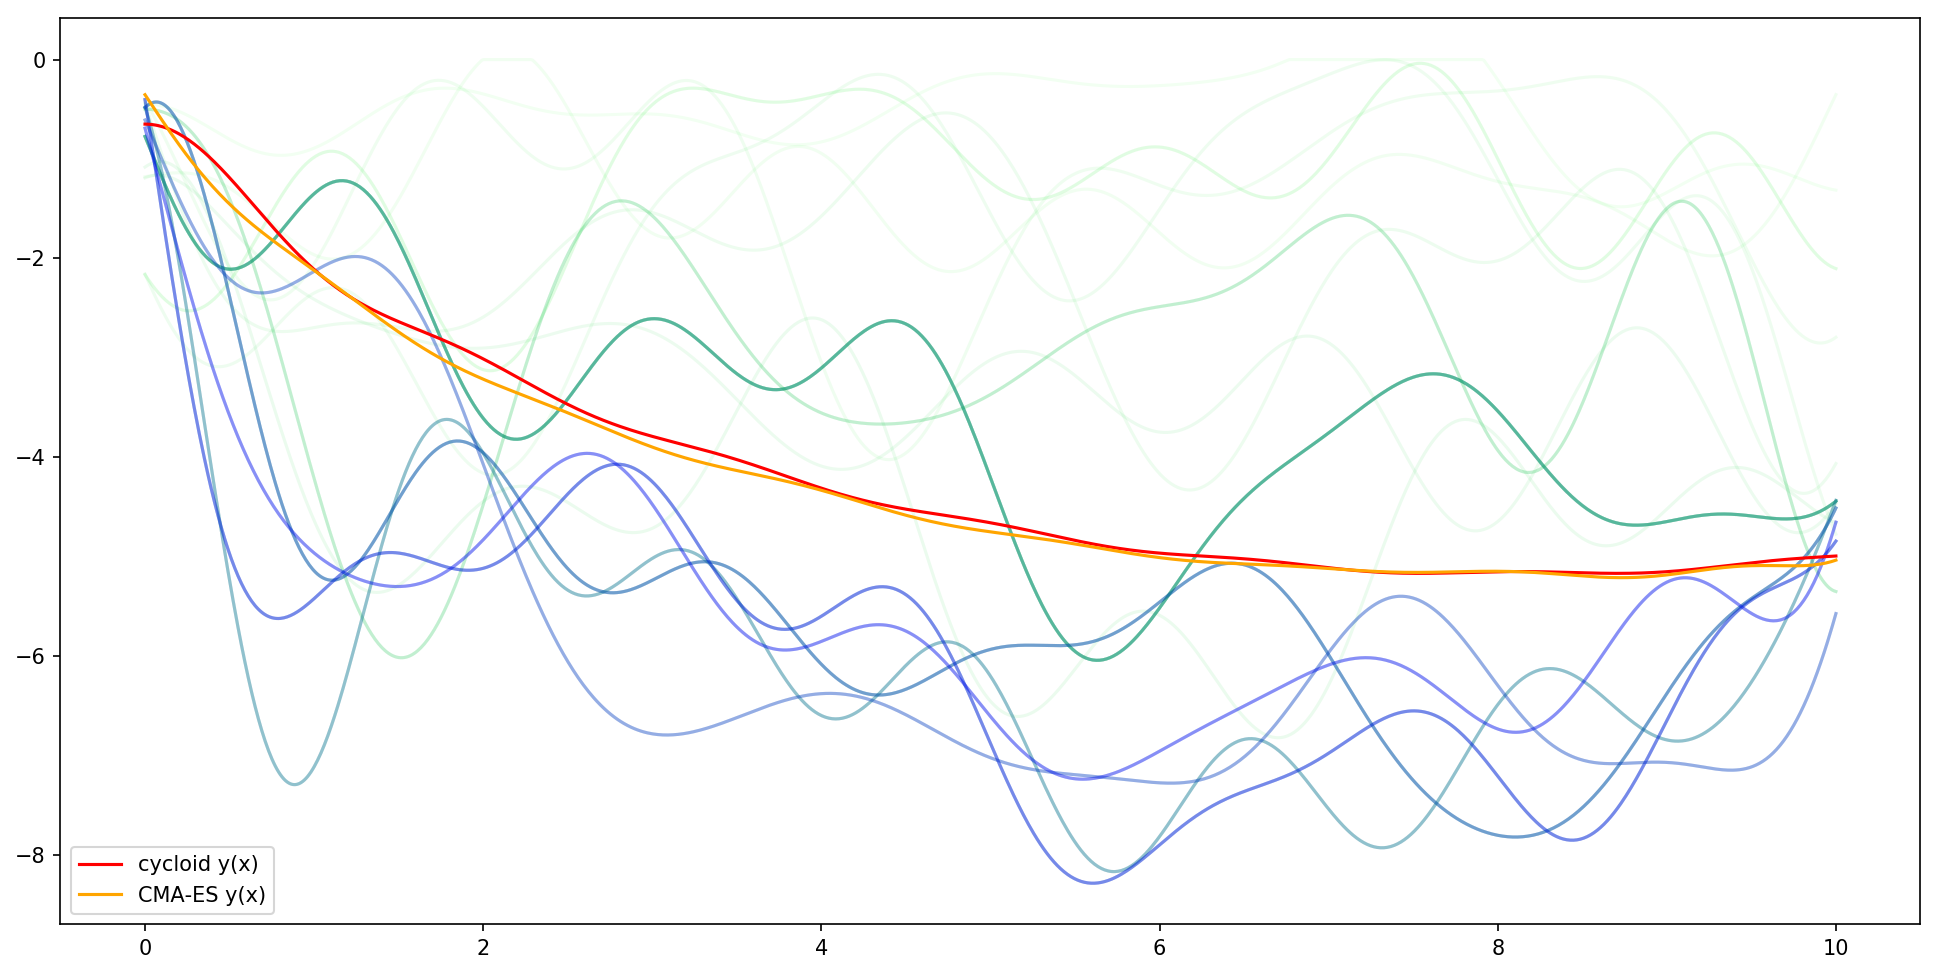

CYCLOID:
  fitness: -1.7441541442885375
CMA-ES:
  fitness: -1.5837257911659532


In [35]:
cma_coefs = cma_history[-1][0]
plt.figure(figsize=(16,8), dpi=150)
for i in range(len(cma_coefs)-1):
    yaxis_temp = fourier_y(cma_history[i][0],xaxis)
    plt.plot(xaxis, yaxis_temp, color=(0.0, 1.0-(i/len(cma_coefs)), (i/len(cma_coefs))),alpha=0.05+0.15*(i/len(cma_coefs)))
yaxis_cma = fourier_y(cma_coefs,xaxis)
cycloid_y, = plt.plot(xaxis, yaxis_cycloid, color="red",label='cycloid y(x)')
cma_y, = plt.plot(xaxis, yaxis_cma, color="orange",label='CMA-ES y(x)')
plt.legend(handles=[cycloid_y,cma_y], loc=3)
plt.show()

print('CYCLOID:')
print('  fitness:',cost_function(cycloid_coefs))
print('CMA-ES:')
print('  fitness:',cost_function(cma_coefs))

In [21]:
# defines OpenAI's ES algorithm solver. Note that we needed to anneal the sigma parameter
oes = OpenES(NPARAMS,                  # number of model parameters
            sigma_init=0.5,            # initial standard deviation
            sigma_decay=0.999,         # don't anneal standard deviation
            learning_rate=0.1,         # learning rate for standard deviation
            learning_rate_decay = 1.0, # annealing the learning rate
            popsize=NPOPULATION,       # population size
            antithetic=False,          # whether to use antithetic sampling
            weight_decay=0.00,         # weight decay coefficient
            rank_fitness=False,        # use rank rather than fitness numbers
            forget_best=False)

In [22]:
oes_history = test_solver(oes)

/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


fitness at iteration 0 -677.21566727
fitness at iteration 2 -543.008365733
fitness at iteration 4 -118.038590206
fitness at iteration 6 -112.359884549
fitness at iteration 8 -43.5712344411
fitness at iteration 10 -7.97782146911


/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  warnings.warn(msg, IntegrationWarning)


fitness at iteration 12 -7.97782146911
fitness at iteration 14 -6.62680910459
fitness at iteration 16 -4.99885303647
fitness at iteration 18 -3.93482578353
fitness at iteration 20 -3.93482578353
fitness at iteration 22 -3.93482578353
fitness at iteration 24 -3.93482578353
fitness at iteration 26 -3.93482578353
fitness at iteration 28 -3.16109881719
fitness at iteration 30 -3.16109881719
fitness at iteration 32 -3.16109881719
fitness at iteration 34 -3.16109881719
fitness at iteration 36 -3.16109881719
fitness at iteration 38 -3.16109881719
fitness at iteration 40 -3.16109881719
fitness at iteration 42 -3.16109881719
fitness at iteration 44 -3.16109881719
fitness at iteration 46 -3.16109881719
fitness at iteration 48 -3.16109881719
fitness at iteration 50 -3.16109881719
fitness at iteration 52 -3.16109881719
fitness at iteration 54 -3.16109881719
fitness at iteration 56 -3.16109881719
fitness at iteration 58 -3.16109881719
fitness at iteration 60 -3.16109881719
fitness at iteration 62 -

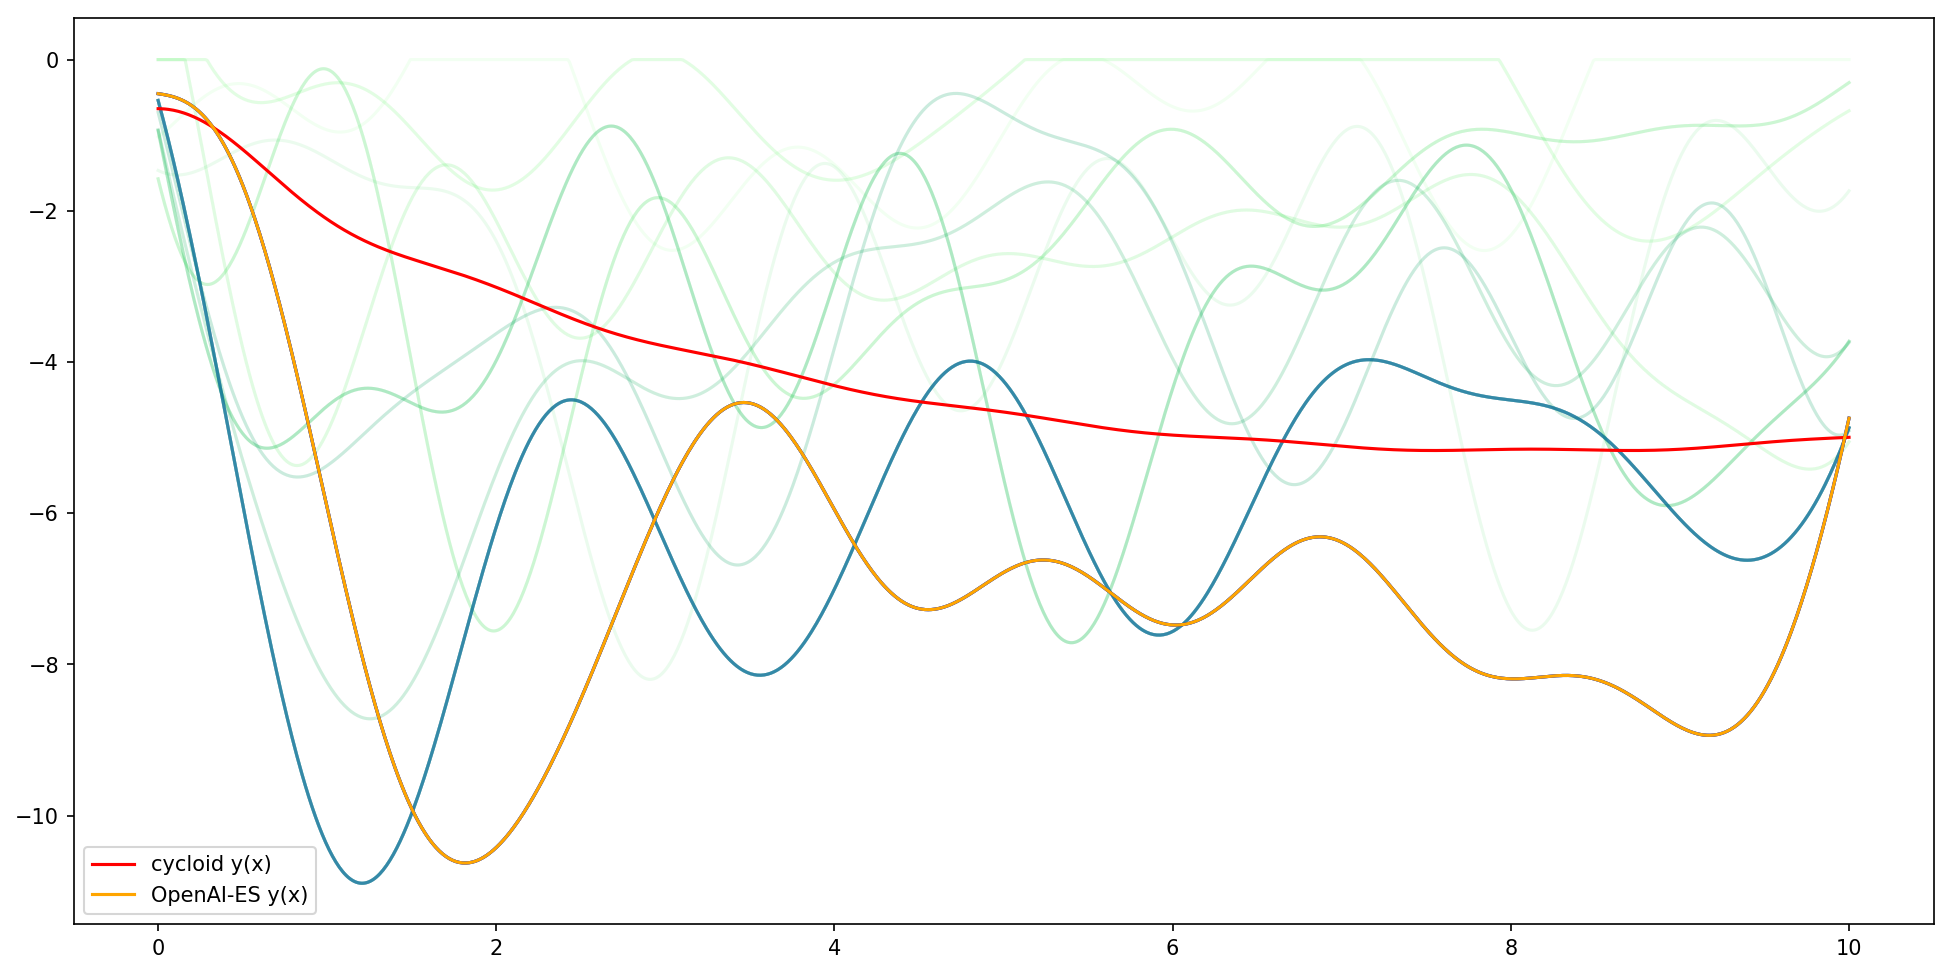

CYCLOID:
  fitness: -1.7441541442885375
OpenAI-ES:
  fitness: -3.161098817186239


In [36]:
oes_coefs = oes_history[-1][0]
plt.figure(figsize=(16,8), dpi=150)
for i in range(len(oes_coefs)-1):
    yaxis_temp = fourier_y(oes_history[i][0],xaxis)
    plt.plot(xaxis, yaxis_temp, color=(0.0, 1.0-(i/len(cma_coefs)), (i/len(cma_coefs))),alpha=0.05+0.15*(i/len(cma_coefs)))
yaxis_oes = fourier_y(oes_coefs,xaxis)
cycloid_y, = plt.plot(xaxis, yaxis_cycloid, color="red",label='cycloid y(x)')
oes_y, = plt.plot(xaxis, yaxis_oes, color="orange",label='OpenAI-ES y(x)')
plt.legend(handles=[cycloid_y,oes_y], loc=3)
plt.show()

print('CYCLOID:')
print('  fitness:',cost_function(cycloid_coefs))
print('OpenAI-ES:')
print('  fitness:',cost_function(oes_coefs))

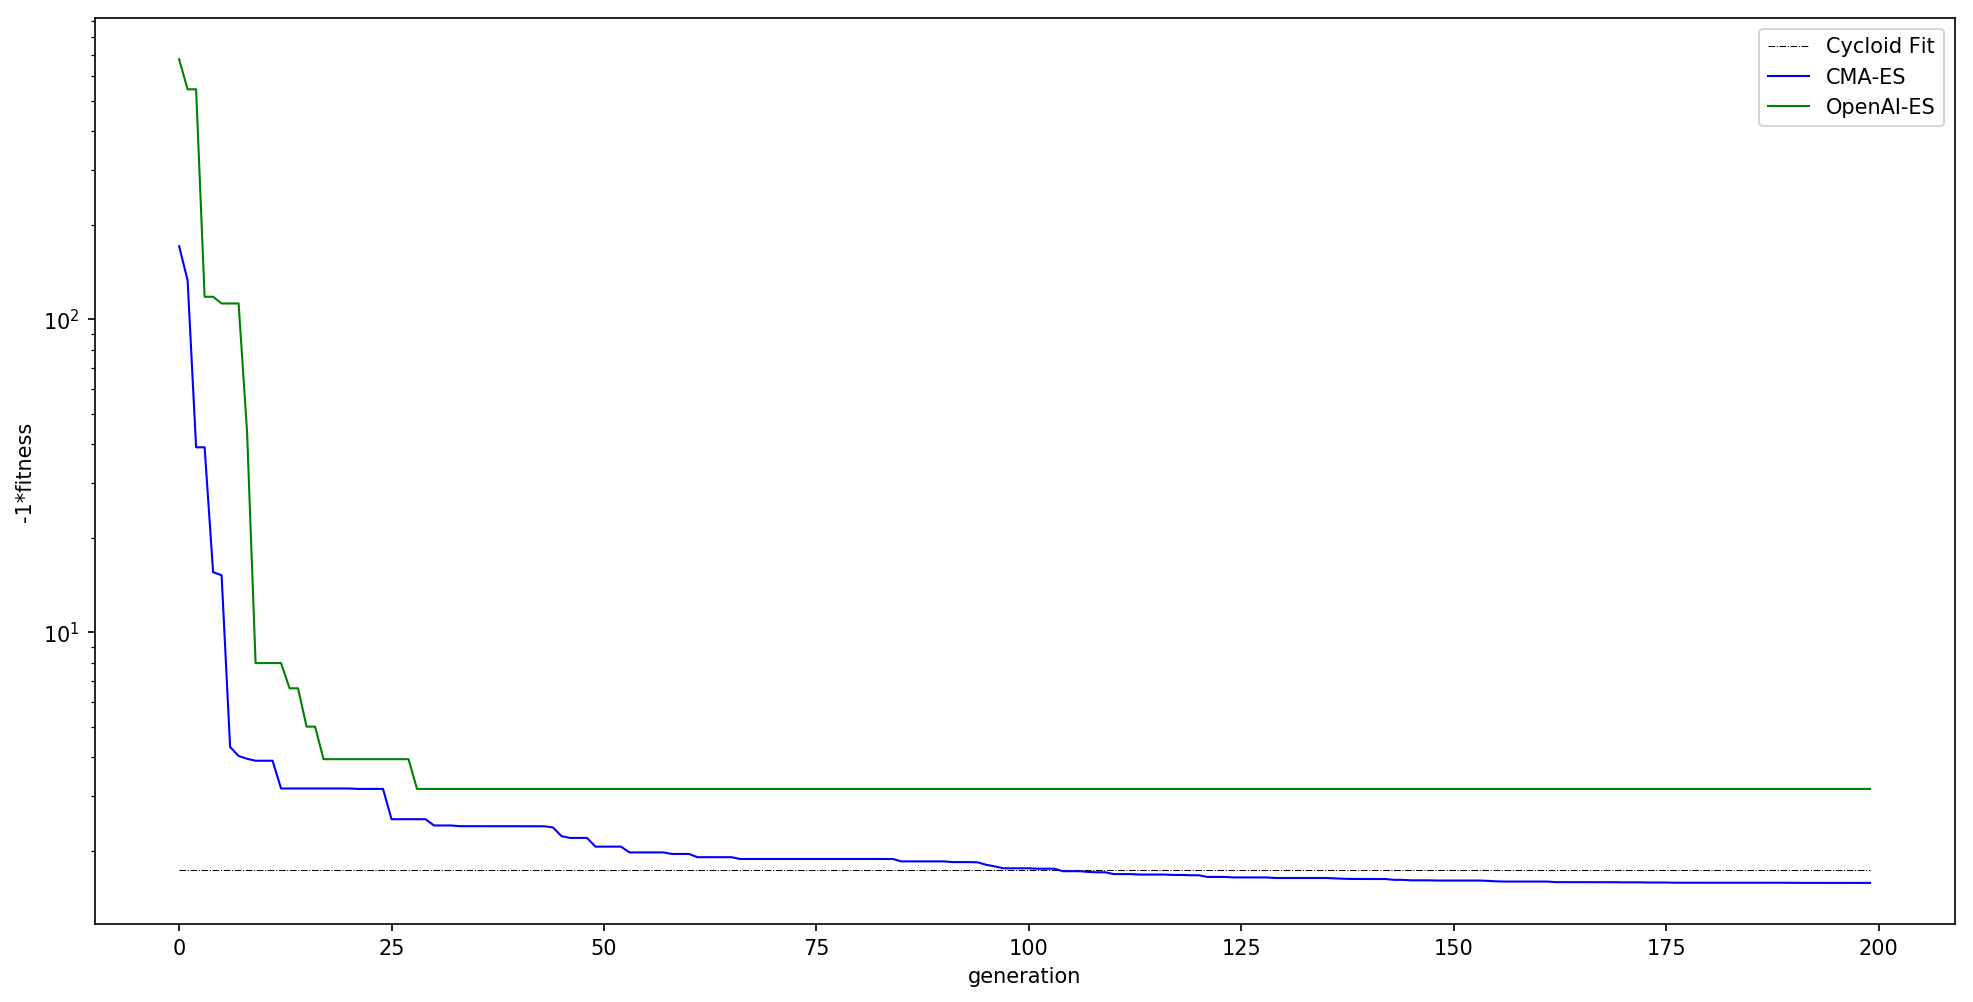

In [30]:
cycloid_fitness = [-cost_function(cycloid_coefs)] * MAX_ITERATION
plt.figure(figsize=(16,8), dpi=150)

oes_fitness = [-i[1] for i in oes_history ]
cma_fitness = [-i[1] for i in cma_history ]

cycloid_line, = plt.semilogy(cycloid_fitness, color="black", linewidth=0.5, linestyle="-.", label='Cycloid Fit')
oes_line, = plt.semilogy(oes_fitness, color="green", linewidth=1.0, linestyle="-", label='OpenAI-ES')
cma_line, = plt.semilogy(cma_fitness, color="blue", linewidth=1.0, linestyle="-", label='CMA-ES')

plt.legend(handles=[cycloid_line, cma_line, oes_line], loc=1)

# Set x limits
#plt.xlim(0,2500)

plt.xlabel('generation')
plt.ylabel('-1*fitness')

# plt.savefig("./rastrigin_10d.svg")

plt.show()